# Module combination notebook

This notebook combines all the feature for the stochastic data (see section ?? of the paper).

The input files for this notebook are:
- master list: should be located in the root folder;
- feature files: .CSV files located in the module folders;

The output files for this notebook are:
- model: pickle file of the trained model;
- MDA files: model design analysis files and some files produced for monitoring;

<img align="left" width="678" height="344" src="../assets/model.png">

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")

from feature_engineering import *
from utils import *

In [3]:
master_list = pd.read_csv('../master_list_v3_DBI.csv')
master_list['close_time'] = pd.to_datetime(master_list['close_time'])

print(len(master_list))
print(master_list['target'].value_counts())

2599
 0    1645
 1     568
-1     386
Name: target, dtype: int64


# Combine

In [4]:
modules = [
            '01_candlestick_data', 
            '02_indicators', 
            '03_exchange_data',
            '04_stochastic_process'
          ]

combined_features = master_list
for module in modules:
    module_features = pd.read_csv(f'../{module}/features.csv')
    if 'target' in module_features.columns:
        module_features = module_features.drop(columns=['target'])
    module_features['close_time'] = pd.to_datetime(module_features['close_time'])
    combined_features = combined_features.merge(module_features, how='left', on='close_time')
combined_features = combined_features.drop_duplicates(subset=['close_time']).reset_index(drop=True)

In [5]:
combined_features.head()

,close_time,target,week_day,hour,returns_1,returns_4,Garman_Klass_HV_4,volume_1,volume_4,candle_size_mean_candle_size_12_ratio,...,ba_spread,variations,norm_dists,cauchy_dists,lengthscale_Matern32,p_value_KS_Matern32,p_value_SW_Matern32,lengthscale_OU,p_value_KS_OU,p_value_SW_OU
0,2021-01-02 15:59:59.999,1,5,15,0.001261,0.002262,0.002121,0.117482,-0.173746,0.001262,...,20.849609,1064.6387,0.340526,0.223882,5.0,0.223603,2.431316e-03,20.0,0.499257,6.453851e-04
1,2021-01-02 23:59:59.999,-1,5,23,-0.001355,0.000465,0.006262,0.071183,-0.720425,0.001388,...,51.308594,7941.9883,0.318472,0.200958,10.0,0.757100,2.297320e-02,105.0,0.133927,7.471986e-04
2,2021-01-03 08:29:59.999,1,6,8,-0.001567,-0.002239,0.003842,0.740627,0.553150,0.001564,...,21.031250,3590.1953,0.316142,0.212906,5.0,0.291288,5.999144e-08,105.0,0.609243,6.083976e-09
3,2021-01-04 11:14:59.999,-1,0,11,-0.010896,-0.007171,0.005966,0.243592,0.848024,0.010838,...,171.898438,12656.0470,0.293350,0.170090,5.0,0.024521,1.055584e-01,10.0,0.571794,5.303660e-02
4,2021-01-06 07:44:59.999,1,2,7,0.000024,-0.007656,0.005634,0.279452,0.204350,0.000066,...,27.878906,5354.3047,0.342542,0.233590,5.0,0.658311,4.288365e-03,55.0,0.449183,2.354663e-03


In [6]:
# plt.figure(figsize=(20, 18), dpi=150)
# sns.heatmap(combined_features.corr(numeric_only=True).round(2), annot=True)
# plt.show()

In [7]:
# Correlation check
corr_df = combined_features.corr(numeric_only=True).round(2)
corr_df.to_csv('corr.csv')

# Train/test split

In [8]:
Xy = combined_features.drop(columns=['close_time'])
Xy['target'] = Xy['target'].replace(-1, 1)

In [9]:
Xy_train = Xy[:2000].reset_index(drop=True)
Xy_test = Xy[2000:].reset_index(drop=True)

In [10]:
X_train = Xy_train.drop(columns=['target'])
X_test = Xy_test.drop(columns=['target'])
y_train = Xy_train['target']
y_test = Xy_test['target']

In [11]:
# PSI check
def psi(df1, df2):
    psi_df1 = deepcopy(df1)
    psi_df1['count'] /= len(X_train)
    psi_df1['ln_count'] = np.log(psi_df1['count'])

    psi_df2 = deepcopy(df2)
    psi_df2['count'] /= len(X_test)
    psi_df2['ln_count'] = np.log(psi_df2['count'])

    psi_df_comp = pd.concat((psi_df1, psi_df2), axis=1)
    psi_df_comp.columns = ['count1', 'ln_count1', 'count2', 'ln_count2']
    psi_df_comp = psi_df_comp[(psi_df_comp['ln_count1'] != -np.inf) & (psi_df_comp['ln_count2'] != -np.inf)]
    
    psi = ((psi_df_comp['count1'] - psi_df_comp['count2']) * (psi_df_comp['ln_count1'] - psi_df_comp['ln_count2'])).sum()
    return round(psi, 4)

psi_values = []
for col in X_train.columns:
    try:
        _, bins = pd.qcut(X_train[col], q=5, retbins=True)
    except:
        continue

    dev_count = pd.DataFrame(pd.cut(X_train[col], bins=bins, labels=range(len(bins)-1))).reset_index(names='count').groupby(col).count()
    test_count = pd.DataFrame(pd.cut(X_test[col], bins=bins, labels=range(len(bins)-1))).reset_index(names='count').groupby(col).count()

    psi_values.append([col, psi(dev_count, test_count)])
    
psi_df = pd.DataFrame(psi_values)
psi_df.columns = ['Feature', 'PSI']

# Model

In [12]:
final_features = [
    'week_day',
    'hour',
    'Garman_Klass_HV_4',
    'candle_size_mean_candle_size_12_ratio',
    'num_trades',
    'MA_5_under_MA_100',
    'bbw%',
    'smoothed_RSI',
    'CMF',
    'coefs',
    'kurtosises',
#     'sell_amounts',
    'variations'
]

In [13]:
clf = lgbm.LGBMClassifier(n_estimators=50, 
                   max_depth=4,
                   min_child_samples=30,
                   random_state=42,
                   verbose=-1)

clf.fit(X_train[final_features], y_train)
pred = clf.predict_proba(X_test[final_features])

In [14]:
pickle.dump(clf, open('lgbm_model.pkl', 'wb'))

## Metrics

In [15]:
print('AUC TEST: \t', roc_auc_score(y_test, pred[:, 1]))
print('AUC TRAIN: \t', roc_auc_score(y_train, clf.predict_proba(X_train[final_features])[:, 1]))

AUC TEST: 	 0.7933510276303253
AUC TRAIN: 	 0.9206306611630694


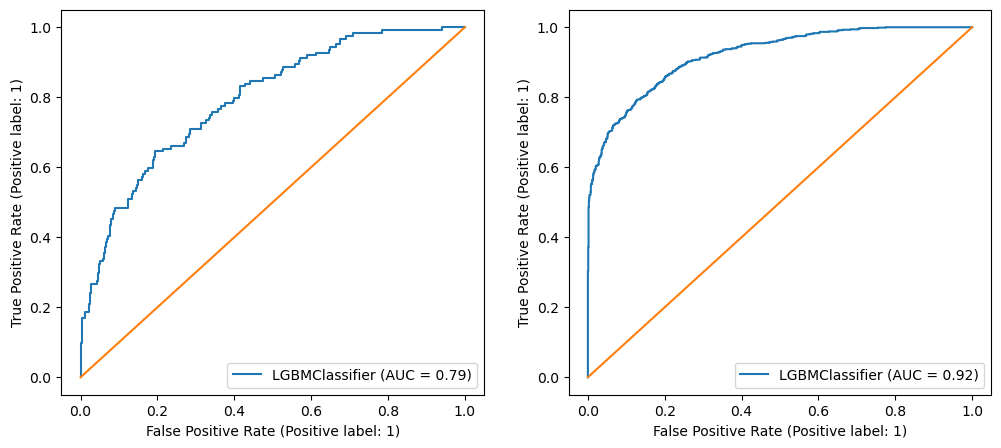

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sklearn.metrics.plot_roc_curve(clf, X_test[final_features], y_test, ax=ax[0])
ax[0].plot([0,1], [0,1])
sklearn.metrics.plot_roc_curve(clf, X_train[final_features], y_train, ax=ax[1])
ax[1].plot([0,1], [0,1])
plt.show()

In [17]:
print(classification_report(y_test, np.where(pred[:, 1] > 0.5, 1, 0)))
print('-'*60)
pred_train = clf.predict_proba(X_train[final_features])
print(classification_report(y_train, np.where(pred_train[:, 1] > 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       474
           1       0.59      0.40      0.47       124

    accuracy                           0.82       598
   macro avg       0.72      0.66      0.68       598
weighted avg       0.80      0.82      0.80       598

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1171
           1       0.90      0.70      0.79       829

    accuracy                           0.84      2000
   macro avg       0.86      0.82      0.83      2000
weighted avg       0.85      0.84      0.84      2000



## Recursive feature elimination

In [18]:
# Recursive feature elimination
selector = RFE(clf, n_features_to_select=13, verbose=0)
selector.fit(X_train, y_train)

print(selector.get_feature_names_out(X_train.columns))
print(roc_auc_score(y_test, selector.predict_proba(X_test)[:, 1]))

['week_day' 'hour' 'volume_4' 'num_trades' 'bbw%' 'smoothed_RSI' 'coefs'
 'percentile_90' 'ba_spread' 'variations' 'norm_dists' 'cauchy_dists'
 'p_value_KS_Matern32']
0.75626105893562


## Information gain

In [ ]:
order = [s[0] for s in sorted_features]

In [ ]:
ig = mutual_info_regression(X_test[order], y_test)

feature_scores = {}
for i in range(len(X_train.columns)):
    feature_scores[order[i]] = ig[i]

sorted_features = feature_scores #sorted(feature_scores.items(), key=order, reverse=True)

fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features.items()], align="center", color='gray', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features.items()])
ax.invert_yaxis()
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

for i, v in enumerate([score for feature, score in sorted_features.items()]):
    ax.text(v + 0.005, i+0.25, str(round(v, 3)), color="black") 
    
for d in['left', 'right', 'top', 'bottom']:
    ax.spines[d].set_visible(False)
    
ax.axes.get_xaxis().set_visible(False)

plt.tight_layout()
plt.savefig('information_gain_test.png')
plt.show()

## Feature importances 

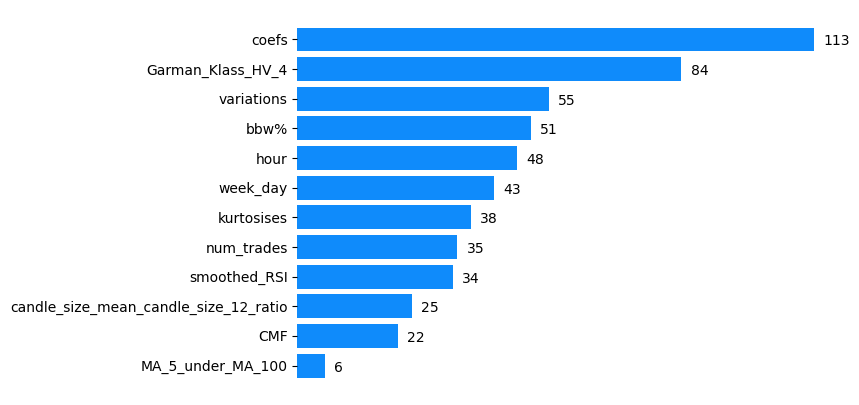

In [19]:
# Feature importance
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

ax.barh(np.array(clf.booster_.feature_name())[np.argsort(clf.feature_importances_)[::-1]], 
        sorted(clf.feature_importances_, reverse=True), 
        align="center", color=(0.06, 0.544, 0.986), edgecolor=(0.06, 0.544, 0.986), linewidth=0)
for i, v in enumerate(sorted(clf.feature_importances_, reverse=True)):
    ax.text(v + 2, i+0.2, str(round(v, 3)), color="black") 
    
for d in['left', 'right', 'top', 'bottom']:
    ax.spines[d].set_visible(False)
    
ax.axes.get_xaxis().set_visible(False)
ax.invert_yaxis()
    
plt.show()

## Buckets split

In [20]:
res_df = pd.DataFrame()
res_df['pred'] = pred[:, 1]
res_df['target'] = y_test.values

res_df = res_df.sort_values(by='pred').reset_index(drop=True)

bad_rate = []
for bucket in np.array_split(res_df, 20):
    bad_rate.append(bucket['target'].mean())
print('Last bucket has the bad rate of:', round(100 * np.sum(bad_rate[-2:]) / 20, 2), '%')

Last bucket has the bad rate of: 6.21 %


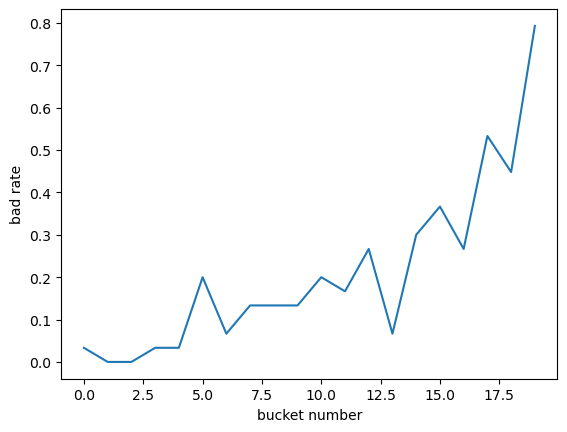

In [21]:
fig, ax = plt.subplots(1, 1)
ax.plot(bad_rate)
ax.set_xlabel('bucket number')
ax.set_ylabel('bad rate')
plt.show()

# SHAP values

### PDPs

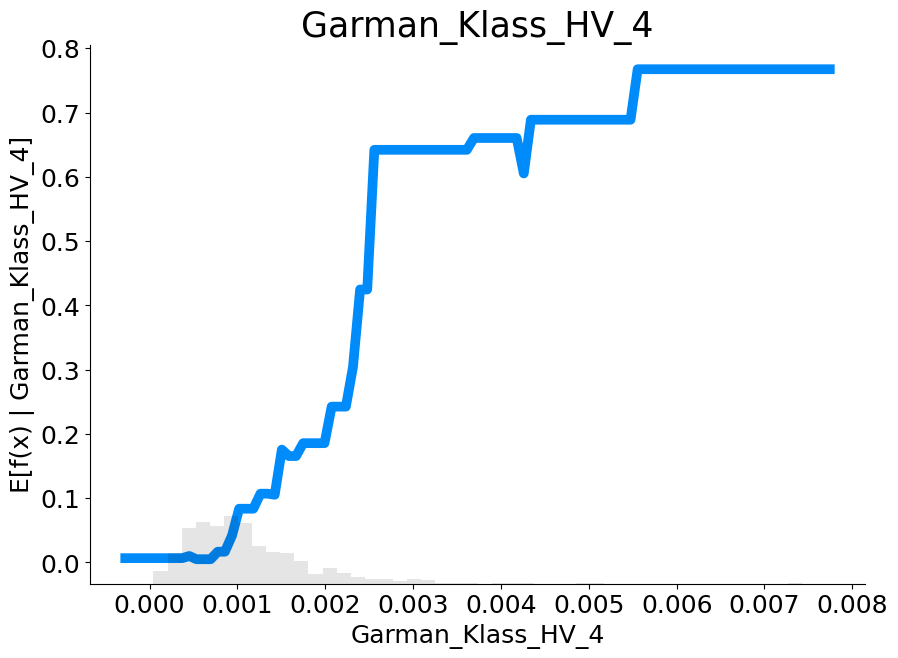

In [22]:
f = 'Garman_Klass_HV_4'

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.title(f, fontsize = 25)
shap.plots.partial_dependence(f, clf.predict, X_test[final_features], ice=False, ax=ax, show=False, pd_linewidth=7)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel(f, fontsize=18)
ax.set_ylabel(f'E[f(x) | {f}]', fontsize=18)
plt.show()

## SHAP values & interaction

In [23]:
explainer = shap.Explainer(clf, X_train[final_features])
shap_values_dev = explainer(X_train[final_features])

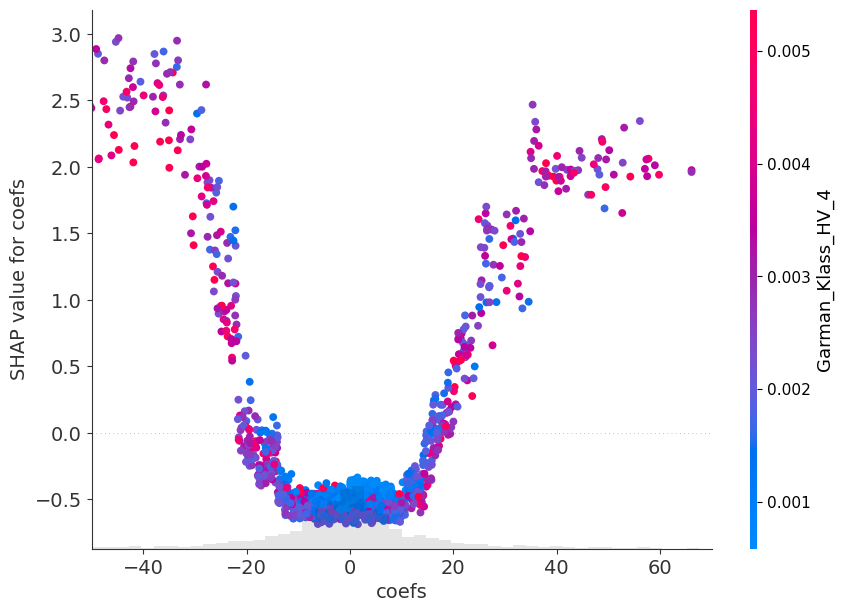

In [24]:
f = 'coefs'

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
shap.plots.scatter(shap_values_dev[:, f], color=shap_values_dev, ax=ax, show=False, dot_size=32, xmin=-50, xmax=70)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(f, fontsize=14)
ax.set_ylabel(f'SHAP value for {f}', fontsize=14)
plt.show()

## Decision plots

In [25]:
explainer = shap.TreeExplainer(clf)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(598)
features = X_test[final_features].iloc[select]
features_display = X_test[final_features].loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-0.30674971]


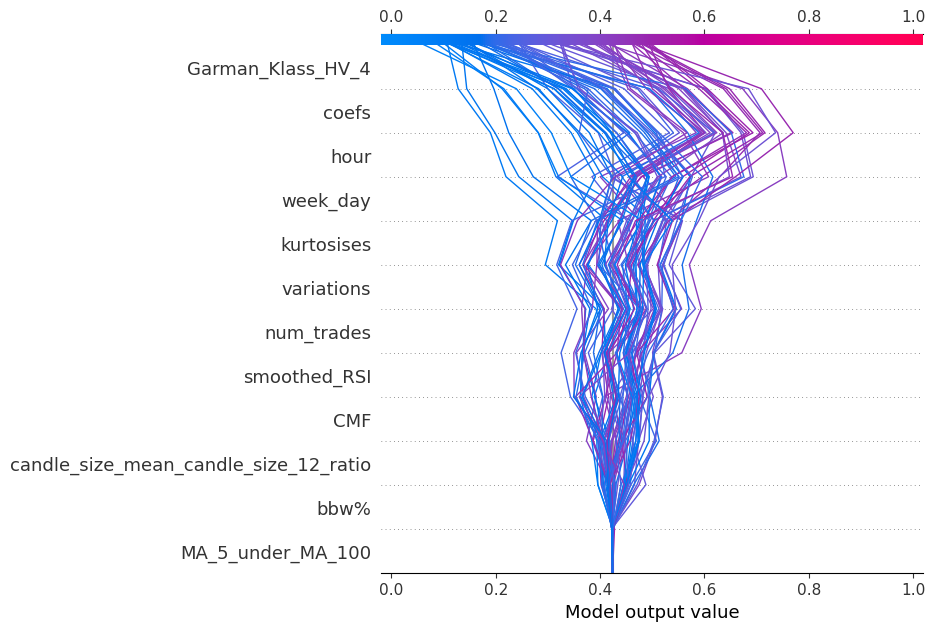

In [26]:
# Check the missclassified examples (FN & FP)
y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = (y_pred == 0) & (y_test[select] == 1)


fig = shap.decision_plot(expected_value, 
                         shap_values[misclassified], 
                         features_display[misclassified], 
                         link='logit', 
                         show=False, 
                         return_objects=True, 
                         feature_order=[5, 6, 3, 8, 7, 4, 11, 10, 0, 1, 9, 2])

_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(7, 7)

plt.show()